#Dataset Importing

In [1]:
import kagglehub

# Download dataset
sohonjit_signature_dataset_path = kagglehub.dataset_download('sohonjit/signature-dataset')
print("Dataset downloaded at:", sohonjit_signature_dataset_path)

100%|██████████| 242M/242M [00:12<00:00, 20.9MB/s]

Extracting files...


Dataset downloaded at: /root/.cache/kagglehub/datasets/sohonjit/signature-dataset/versions/1


#Loading Data

In [2]:
import os
import torch
from torch.utils.data import Dataset
from torchvision.transforms import transforms
from PIL import Image
import numpy as np

class SigDataset(Dataset):
    def __init__(self, original_path, forge_path):
        self.original_path = original_path
        self.forge_path = forge_path
        # Filter out filenames that do not have at least one underscore
        valid_files = [f for f in os.listdir(original_path) if '_' in f and len(f.split('_')) > 1]
        self.people = [f.split('_')[1] for f in valid_files]

    def __len__(self):
        return 5000  # Arbitrary large number to simulate infinite data

    def __getitem__(self, idx):
        person_id = np.random.randint(1, 56)
        sample = np.random.randint(1, 24)
        label = np.random.randint(0, 2)

        org_img_name = f'original_{person_id}_{sample}.png'
        org_img_path = os.path.join(self.original_path, org_img_name)
        org_img = Image.open(org_img_path).convert('RGB')

        aug = transforms.Compose([
            transforms.Resize((155, 220)),
            transforms.ToTensor()
        ])

        org_tensor = aug(org_img)

        if label == 0:
            sample1 = np.random.randint(1, 24)
            forg_img_name = f'forgeries_{person_id}_{sample1}.png'
            forg_img_path = os.path.join(self.forge_path, forg_img_name)
            forg_img = Image.open(forg_img_path).convert('RGB')
            forg_tensor = aug(forg_img)
            return org_tensor, forg_tensor, torch.tensor(label, dtype=torch.float32)
        else:
            sample2 = np.random.randint(1, 24)
            sim_img_name = f'original_{person_id}_{sample2}.png'
            sim_img_path = os.path.join(self.original_path, sim_img_name)
            sim_img = Image.open(sim_img_path).convert('RGB')
            sim_tensor = aug(sim_img)
            return org_tensor, sim_tensor, torch.tensor(label, dtype=torch.float32)

#Creating CNN + Siamese Model

In [3]:
import torch.nn as nn

class SigNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(0.3),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(0.3),

            nn.Flatten(),
            nn.Linear(256 * 17 * 25, 1024),
            nn.Linear(1024, 128)
        )

    def forward(self, img1, img2):
        out1 = self.feature_extractor(img1)
        out2 = self.feature_extractor(img2)
        return out1, out2

#Creating Contrast Function

In [4]:
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        distance = F.pairwise_distance(output1, output2)
        loss = torch.mean((1 - label) * distance.pow(2) +
                          label * torch.clamp(self.margin - distance, min=0).pow(2))
        return loss

#random Images

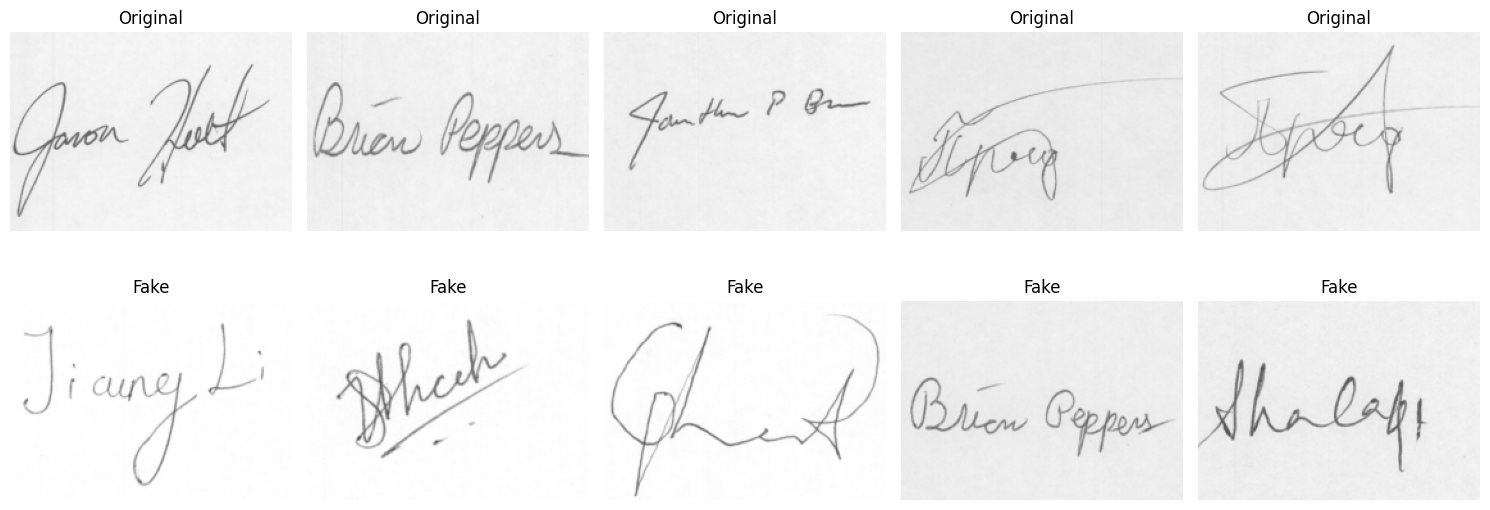

In [5]:

import matplotlib.pyplot as plt
import os
import torch
from torchvision.transforms import transforms
from PIL import Image
import numpy as np
from torch.utils.data import Dataset # Import Dataset here

# Assuming SigDataset class is defined elsewhere in the notebook

# Instantiate the dataset
# Corrected paths based on the training section
original_path = os.path.join(sohonjit_signature_dataset_path, 'signatures/full_org')
forge_path = os.path.join(sohonjit_signature_dataset_path, 'signatures/full_forg')
dataset = SigDataset(original_path, forge_path)

# Show 5 original and 5 fake signs
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(5):
    # Get an original/original pair (assuming the dataset generates these)
    # You might need to adjust this if your dataset only generates original/forgery pairs
    # For demonstration, we'll assume getting item 0 gives a valid sample
    org_tensor, sim_tensor, label = dataset[np.random.randint(0, len(dataset))] # Get a random sample
    # Ensure we are displaying an original image
    # If label is 0 (forgery pair), the second image is a forgery.
    # If label is 1 (genuine pair), the second image is another original.
    # To show 5 original signs, let's just get the first image of the pair, which is always original.
    org_tensor, _, _ = dataset[np.random.randint(0, len(dataset))]
    axes[i].imshow(org_tensor.permute(1, 2, 0))
    axes[i].set_title("Original")
    axes[i].axis('off')

for i in range(5, 10):
    # Get an original/forgery pair (assuming the dataset generates these with some probability)
    # To show 5 fake signs, we need to specifically get samples where the second image is a forgery.
    # The dataset generates a forgery if label is 0.
    # We can repeatedly sample until we get 5 forgery pairs or modify the dataset logic for visualization.
    # For this example, let's just get the second image from the dataset sample for the "Fake" plot.
    # Note: This might show original images if the randomly sampled 'label' is 1.
    # A more robust approach would be to sample until you get a forgery pair.
    # However, given the current dataset logic, the second image is a forgery if label is 0.
    # Let's rely on the dataset's random generation for simplicity in this fix.
    _, second_tensor, label = dataset[np.random.randint(0, len(dataset))]
    axes[i].imshow(second_tensor.permute(1, 2, 0)) # Display the second image from the pair
    axes[i].set_title("Fake")
    axes[i].axis('off')


plt.tight_layout()
plt.show()

Showing signatures for person ID: 37


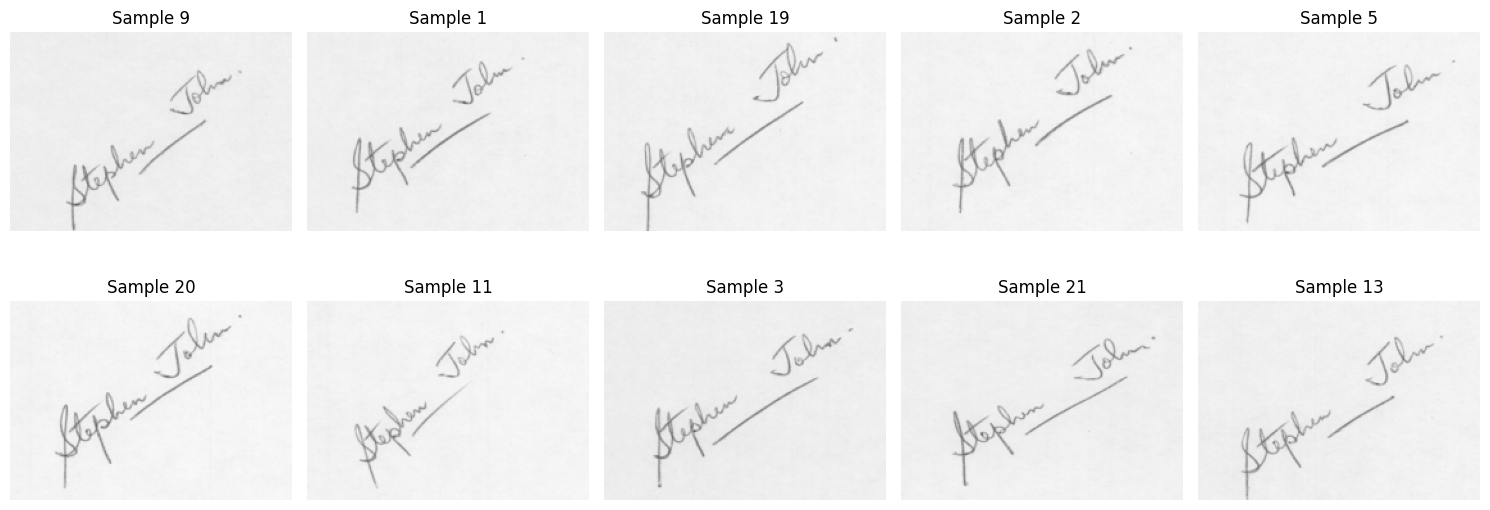

In [6]:
# prompt: show same person signatures upto 10

# Show 10 genuine signatures for the same person
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Select a random person ID
person_id = np.random.randint(1, 56)

print(f"Showing signatures for person ID: {person_id}")

# List to store the samples we have displayed for this person
displayed_samples = []

for i in range(10):
    sample = np.random.randint(1, 24)
    # Ensure we don't display the same sample multiple times in this grid if possible
    while sample in displayed_samples and len(displayed_samples) < 23: # Max samples per person is 23
         sample = np.random.randint(1, 24)
    displayed_samples.append(sample)

    # Construct the image name for a genuine signature
    img_name = f'original_{person_id}_{sample}.png'
    img_path = os.path.join(original_path, img_name)

    try:
        img = Image.open(img_path).convert('RGB')
        aug = transforms.Compose([
            transforms.Resize((155, 220)),
            transforms.ToTensor()
        ])
        img_tensor = aug(img)
        axes[i].imshow(img_tensor.permute(1, 2, 0))
        axes[i].set_title(f"Sample {sample}")
        axes[i].axis('off')
    except FileNotFoundError:
        print(f"File not found: {img_path}. Skipping this sample.")
        # If file not found, leave the subplot empty or show a placeholder
        axes[i].text(0.5, 0.5, "Image not found", horizontalalignment='center', verticalalignment='center')
        axes[i].axis('off')


plt.tight_layout()
plt.show()


#Same Person with fake sign 1 original 1 fake

Showing original and fake signatures for person ID: 44


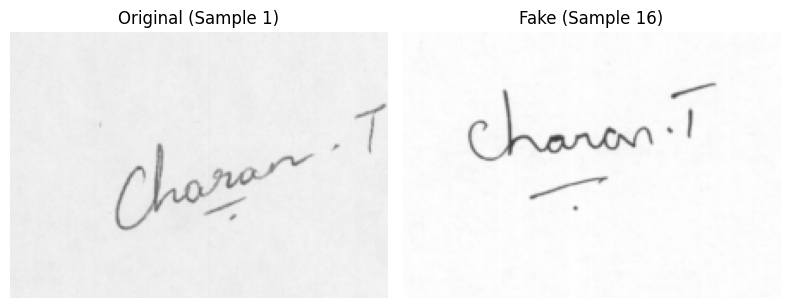

In [7]:
# prompt: #Same Person with fake sign 1 original 1 fake

# Show 1 original and 1 fake signature for the same person
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes = axes.flatten()

# Select a random person ID
person_id = np.random.randint(1, 56)
print(f"Showing original and fake signatures for person ID: {person_id}")

# Display one original signature
original_sample = np.random.randint(1, 24)
org_img_name = f'original_{person_id}_{original_sample}.png'
org_img_path = os.path.join(original_path, org_img_name)

try:
    org_img = Image.open(org_img_path).convert('RGB')
    aug = transforms.Compose([
        transforms.Resize((155, 220)),
        transforms.ToTensor()
    ])
    org_tensor = aug(org_img)
    axes[0].imshow(org_tensor.permute(1, 2, 0))
    axes[0].set_title(f"Original (Sample {original_sample})")
    axes[0].axis('off')
except FileNotFoundError:
    print(f"Original file not found: {org_img_path}. Cannot display original.")
    axes[0].text(0.5, 0.5, "Original Image not found", horizontalalignment='center', verticalalignment='center')
    axes[0].axis('off')


# Display one fake signature for the same person
fake_sample = np.random.randint(1, 24)
forg_img_name = f'forgeries_{person_id}_{fake_sample}.png'
forg_img_path = os.path.join(forge_path, forg_img_name)

try:
    forg_img = Image.open(forg_img_path).convert('RGB')
    forg_tensor = aug(forg_img) # Use the same augmentation
    axes[1].imshow(forg_tensor.permute(1, 2, 0))
    axes[1].set_title(f"Fake (Sample {fake_sample})")
    axes[1].axis('off')
except FileNotFoundError:
    print(f"Fake file not found: {forg_img_path}. Cannot display fake.")
    axes[1].text(0.5, 0.5, "Fake Image not found", horizontalalignment='center', verticalalignment='center')
    axes[1].axis('off')


plt.tight_layout()
plt.show()

#training Model

In [8]:
import torch
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader # Import DataLoader here
import os # Import the os module

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paths
original_dir = os.path.join(sohonjit_signature_dataset_path, 'signatures/full_org')
forge_dir = os.path.join(sohonjit_signature_dataset_path, 'signatures/full_forg')

# Dataset & Dataloader
dataset = SigDataset(original_dir, forge_dir)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Model
model = SigNet().to(device)
criterion = ContrastiveLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training
num_epochs = 10
for epoch in range(num_epochs):
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for img1, img2, label in loop:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        optimizer.zero_grad()
        out1, out2 = model(img1, img2)
        loss = criterion(out1, out2, label)
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())

# Save model
torch.save(model.state_dict(), "sig_net.pth")
print("Model saved!")

Epoch 10/10: 100%|██████████| 157/157 [02:11<00:00,  1.19it/s, loss=6.51e-5]


Model saved!


#Checking

In [9]:
# prompt: create better interface place hard to understandplease update interface for tesing

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output


# Assuming you have defined the SigNet model, sohonjit_signature_dataset_path and device
# These were defined in earlier cells and are available in the global scope.


def load_and_preprocess_image(image_path):
  """Loads and preprocesses an image for model input."""
  try:
    img = Image.open(image_path).convert('RGB')
    aug = transforms.Compose([
        transforms.Resize((155, 220)),
        transforms.ToTensor()
    ])
    return aug(img).unsqueeze(0).to(device) # Add batch dimension and move to device
  except FileNotFoundError:
    # Do not print error here, handle in the calling function for better UI
    return None
  except Exception as e:
    # Do not print error here, handle in the calling function for better UI
    return None

def predict_similarity(model, image_tensor1, image_tensor2, threshold=0.5):
    """Predicts if two images are from the same person based on similarity."""
    if image_tensor1 is None or image_tensor2 is None:
        return "Error: Could not load one or both images.", None

    model.eval()
    with torch.no_grad():
        out1, out2 = model(image_tensor1, image_tensor2)
        distance = F.pairwise_distance(out1, out2).item() # Get scalar distance

    # A smaller distance indicates more similarity.
    if distance < threshold:
        prediction = "The signatures appear to be from the SAME person."
    else:
        prediction = "The signatures appear to be from DIFFERENT persons."

    return prediction, distance

# Load the trained model
try:
    model = SigNet().to(device)
    model.load_state_dict(torch.load("sig_net.pth"))
    model.eval()
    print("Model loaded!")
except FileNotFoundError:
    print("Error: 'sig_net.pth' model file not found. Please ensure the model is trained and saved.")
    # Exit here as the rest of the code depends on the model
    exit()
except Exception as e:
    print(f"Error loading model: {e}")
    # Exit here if the model cannot be loaded
    exit()


# --- Interactive Interface using ipywidgets ---

# Assuming the dataset structure: signatures/full_org and signatures/full_forg
original_dir = os.path.join(sohonjit_signature_dataset_path, 'signatures/full_org')
forge_dir = os.path.join(sohonjit_signature_dataset_path, 'signatures/full_forg')

# Check if dataset directories exist
if not os.path.exists(original_dir):
    print(f"Error: Original signatures directory not found at {original_dir}")
    exit()
if not os.path.exists(forge_dir):
    print(f"Error: Forged signatures directory not found at {forge_dir}")
    exit()

# Get distinct person IDs from the original signatures
valid_org_files = [f for f in os.listdir(original_dir) if '_' in f and len(f.split('_')) > 1]
available_person_ids = sorted(list(set([f.split('_')[1] for f in valid_org_files])))

if not available_person_ids:
    print("No original signatures found in the dataset directory.")
    exit()

# Widgets
person_id_dropdown = widgets.Dropdown(
    options=available_person_ids,
    description='Person ID:',
    disabled=False,
)

img1_type_dropdown = widgets.Dropdown(
    options=['original', 'fake'],
    description='Image 1 Type:',
    disabled=False,
)

img2_type_dropdown = widgets.Dropdown(
    options=['original', 'fake'],
    description='Image 2 Type:',
    disabled=False,
)

img1_sample_dropdown = widgets.Dropdown(
    options=[],  # Will be populated based on person ID and type
    description='Image 1 Sample:',
    disabled=False,
)

img2_sample_dropdown = widgets.Dropdown(
    options=[],  # Will be populated based on person ID and type
    description='Image 2 Sample:',
    disabled=False,
)

compare_button = widgets.Button(description="Compare Signatures")
output_area = widgets.Output()

# Function to update sample dropdowns based on selected person ID and image type
def update_sample_dropdowns(*args):
    person_id = person_id_dropdown.value

    # Update Image 1 sample options
    img1_type = img1_type_dropdown.value
    if img1_type == 'original':
        available_samples = sorted([int(f.split('_')[2].split('.')[0]) for f in valid_org_files if f.startswith(f'original_{person_id}_')])
    else: # fake
        available_samples = sorted([int(f.split('_')[2].split('.')[0]) for f in os.listdir(forge_dir) if f.startswith(f'forgeries_{person_id}_')])
    img1_sample_dropdown.options = [str(s) for s in available_samples]
    if not available_samples:
        img1_sample_dropdown.disabled = True
    else:
        img1_sample_dropdown.disabled = False


    # Update Image 2 sample options
    img2_type = img2_type_dropdown.value
    if img2_type == 'original':
        available_samples = sorted([int(f.split('_')[2].split('.')[0]) for f in valid_org_files if f.startswith(f'original_{person_id}_')])
    else: # fake
        available_samples = sorted([int(f.split('_')[2].split('.')[0]) for f in os.listdir(forge_dir) if f.startswith(f'forgeries_{person_id}_')])
    img2_sample_dropdown.options = [str(s) for s in available_samples]
    if not available_samples:
        img2_sample_dropdown.disabled = True
    else:
        img2_sample_dropdown.disabled = False


# Observe changes in person ID and image type dropdowns to update sample dropdowns
person_id_dropdown.observe(update_sample_dropdowns, names='value')
img1_type_dropdown.observe(update_sample_dropdowns, names='value')
img2_type_dropdown.observe(update_sample_dropdowns, names='value')

# Initial update of sample dropdowns
update_sample_dropdowns()

# Function to handle button click and perform prediction
def on_compare_button_clicked(b):
    with output_area:
        clear_output()

        person_id = person_id_dropdown.value
        img1_type = img1_type_dropdown.value
        sample1 = img1_sample_dropdown.value
        img2_type = img2_type_dropdown.value
        sample2 = img2_sample_dropdown.value

        if not sample1 or not sample2:
            print("Please select samples for both images.")
            return

        # Construct image paths
        if img1_type == 'original':
            img1_path = os.path.join(original_dir, f'original_{person_id}_{sample1}.png')
        else:
            img1_path = os.path.join(forge_dir, f'forgeries_{person_id}_{sample1}.png')

        if img2_type == 'original':
            img2_path = os.path.join(original_dir, f'original_{person_id}_{sample2}.png')
        else:
            img2_path = os.path.join(forge_dir, f'forgeries_{person_id}_{sample2}.png')

        # Load and preprocess images
        img1_tensor = load_and_preprocess_image(img1_path)
        img2_tensor = load_and_preprocess_image(img2_path)

        if img1_tensor is None or img2_tensor is None:
            if img1_tensor is None:
                 print(f"Error loading Image 1: File not found at {img1_path}")
            if img2_tensor is None:
                 print(f"Error loading Image 2: File not found at {img2_path}")
            return

        try:
            # Predict and print result
            # Adjust the threshold based on your model's performance
            threshold = 0.7 # Example threshold, needs tuning
            prediction, distance = predict_similarity(model, img1_tensor, img2_tensor, threshold=threshold)

            # Display the images
            fig, axes = plt.subplots(1, 2, figsize=(8, 4))
            axes[0].imshow(Image.open(img1_path).convert('RGB')) # Display raw image for clarity
            axes[0].set_title(f"Image 1 ({img1_type}, Sample {sample1})")
            axes[0].axis('off')

            axes[1].imshow(Image.open(img2_path).convert('RGB')) # Display raw image for clarity
            axes[1].set_title(f"Image 2 ({img2_type}, Sample {sample2})")
            axes[1].axis('off')
            plt.show()

            print(f"Calculated Euclidean distance: {distance:.4f}")
            print(prediction)

        except Exception as e:
            print(f"An error occurred during prediction: {e}")


# Attach handler to the button
compare_button.on_click(on_compare_button_clicked)

# Display the widgets
print("Select images from the dataset to compare:")
display(person_id_dropdown, img1_type_dropdown, img1_sample_dropdown,
        img2_type_dropdown, img2_sample_dropdown, compare_button, output_area)

Model loaded!
Select images from the dataset to compare:


Dropdown(description='Person ID:', options=('1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '…

Dropdown(description='Image 1 Type:', options=('original', 'fake'), value='original')

Dropdown(description='Image 1 Sample:', options=('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'…

Dropdown(description='Image 2 Type:', options=('original', 'fake'), value='original')

Dropdown(description='Image 2 Sample:', options=('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'…

Button(description='Compare Signatures', style=ButtonStyle())

Output()

# Infrence

In [10]:
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image, ImageOps # Import ImageOps explicitly
import numpy as np


def predict_genuine_or_forged(model, original_images, test_image, device, threshold=1.2):
    """
    Predicts if the test signature is Genuine or Forged using average distance from at least 3 matches.

    Args:
        model: Trained Siamese network
        original_images: List of 5 PIL images (known genuine signatures)
        test_image: Single PIL image (signature to verify)
        device: 'cuda' or 'cpu'
        threshold: Distance threshold to consider a match valid

    Returns:
        prediction: "Genuine" or "Forged"
        avg_distance: Average of distances under threshold (up to 3+ matches)
        all_distances: List of all pairwise distances
    """
    transform = transforms.Compose([
        transforms.Lambda(lambda img: ImageOps.invert(img)),
        transforms.Resize((155, 220)),
        transforms.ToTensor()
    ])

    test_tensor = transform(test_image).unsqueeze(0).to(device)

    all_distances = []
    valid_distances = []

    for idx, img in enumerate(original_images):
        img_tensor = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            out1, out2 = model(img_tensor, test_tensor)
            dist = F.pairwise_distance(out1, out2).item()
            print(f"Distance to Reference {idx+1}: {dist:.4f}")
            all_distances.append(dist)
            if dist < threshold:
                valid_distances.append(dist)

    # Use average of at least 3 valid distances
    if len(valid_distances) >= 3:
        avg_distance = sum(valid_distances[:3]) / 3  # Take first 3 valid matches
        prediction = "Genuine"
    else:
        # Not enough good matches
        avg_distance = float('inf') if not valid_distances else min(valid_distances)
        prediction = "Forged"

    return prediction, avg_distance, all_distances

In [11]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.8 MB/s eta 0:00:00


In [12]:

import io
from google.colab import files # Import the 'files' object from google.colab
from PIL import Image

# Upload 5 known signatures of a person
print("Upload 5 known genuine signatures of the same person:")
# Call files.upload() once and store the result
uploaded_files = files.upload()
known_signatures = [Image.open(io.BytesIO(file_content)) for file_content in uploaded_files.values()]

# Upload 1 test signature
print("\nUpload 1 test signature to check:")
test_sig = list(files.upload().values())[0]
test_image = Image.open(io.BytesIO(test_sig))

Upload 5 known genuine signatures of the same person:


Saving IMG_20250513_203643.jpg to IMG_20250513_203643.jpg
Saving IMG_20250513_203720.jpg to IMG_20250513_203720.jpg
Saving IMG_20250513_203758.jpg to IMG_20250513_203758.jpg
Saving IMG_20250513_203840.jpg to IMG_20250513_203840.jpg
Saving IMG_20250513_203901.jpg to IMG_20250513_203901.jpg

Upload 1 test signature to check:


Saving IMG_20250513_204013.jpg to IMG_20250513_204013.jpg


In [13]:
# Run inference
DEFAULT_THRESHOLD = 0.13
prediction, score, all_distances = predict_genuine_or_forged(model, known_signatures, test_image, device, threshold=DEFAULT_THRESHOLD)

print(f"\n--- Inference Using 3 Valid Matches (Threshold: {DEFAULT_THRESHOLD}) ---")
print(f"Prediction: {prediction}")
print(f"Average Distance (from 3 best): {score:.4f}")
print(f"All Distances: {[f'{d:.4f}' for d in all_distances]}")
print("--------------------------------------------------------")

Distance to Reference 1: 0.1228
Distance to Reference 2: 0.1881
Distance to Reference 3: 0.1543
Distance to Reference 4: 0.1783
Distance to Reference 5: 0.1797

--- Inference Using 3 Valid Matches (Threshold: 0.13) ---
Prediction: Forged
Average Distance (from 3 best): 0.1228
All Distances: ['0.1228', '0.1881', '0.1543', '0.1783', '0.1797']
--------------------------------------------------------


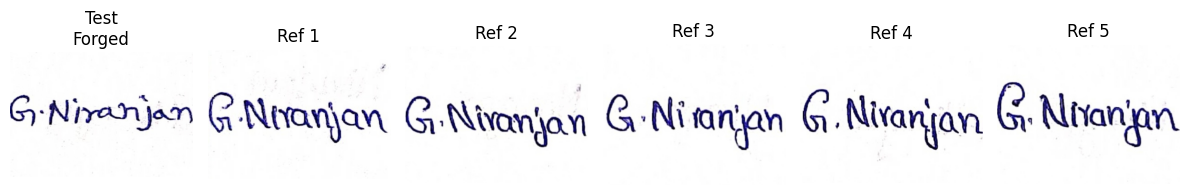

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 6, 1)
plt.imshow(test_image)
plt.title(f"Test\n{prediction}")
plt.axis("off")

for i, sig in enumerate(known_signatures):
    plt.subplot(1, 6, i+2)
    plt.imshow(sig)
    plt.title(f"Ref {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [15]:

import io
from google.colab import files # Import the 'files' object from google.colab
from PIL import Image

# Upload 5 known signatures of a person
print("Upload 5 known genuine signatures of the same person:")
# Call files.upload() once and store the result
uploaded_files = files.upload()
known_signatures = [Image.open(io.BytesIO(file_content)) for file_content in uploaded_files.values()]

# Upload 1 test signature
print("\nUpload 1 test signature to check:")
test_sig = list(files.upload().values())[0]
test_image = Image.open(io.BytesIO(test_sig))

Upload 5 known genuine signatures of the same person:


Saving WhatsApp Image 2025-05-13 at 12.46.39 PM.jpeg to WhatsApp Image 2025-05-13 at 12.46.39 PM.jpeg
Saving WhatsApp Image 2025-05-13 at 12.43.48 PM.jpeg to WhatsApp Image 2025-05-13 at 12.43.48 PM.jpeg
Saving WhatsApp Image 2025-05-13 at 12.43.49 PM.jpeg to WhatsApp Image 2025-05-13 at 12.43.49 PM.jpeg
Saving WhatsApp Image 2025-05-13 at 12.43.47 PM.jpeg to WhatsApp Image 2025-05-13 at 12.43.47 PM.jpeg
Saving WhatsApp Image 2025-05-13 at 12.43.46 PM.jpeg to WhatsApp Image 2025-05-13 at 12.43.46 PM.jpeg

Upload 1 test signature to check:


Saving IMG_20250513_204013.jpg to IMG_20250513_204013 (1).jpg


In [16]:
# Run inference
DEFAULT_THRESHOLD = 0.17
prediction, score, all_distances = predict_genuine_or_forged(model, known_signatures, test_image, device, threshold=DEFAULT_THRESHOLD)

print(f"\n--- Inference Using 3 Valid Matches (Threshold: {DEFAULT_THRESHOLD}) ---")
print(f"Prediction: {prediction}")
print(f"Average Distance (from 3 best): {score:.4f}")
print(f"All Distances: {[f'{d:.4f}' for d in all_distances]}")
print("--------------------------------------------------------")

Distance to Reference 1: 9.1201
Distance to Reference 2: 11.8800
Distance to Reference 3: 9.9642
Distance to Reference 4: 10.1575
Distance to Reference 5: 9.6089

--- Inference Using 3 Valid Matches (Threshold: 0.17) ---
Prediction: Forged
Average Distance (from 3 best): inf
All Distances: ['9.1201', '11.8800', '9.9642', '10.1575', '9.6089']
--------------------------------------------------------


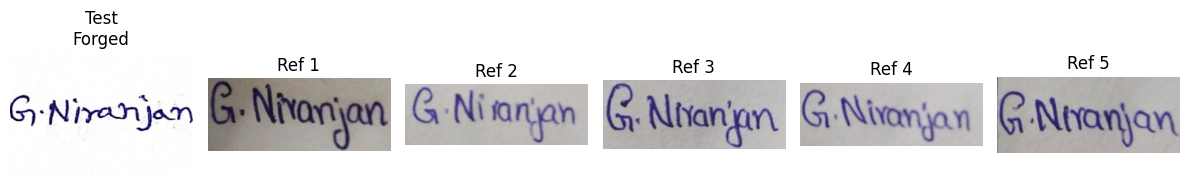

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 6, 1)
plt.imshow(test_image)
plt.title(f"Test\n{prediction}")
plt.axis("off")

for i, sig in enumerate(known_signatures):
    plt.subplot(1, 6, i+2)
    plt.imshow(sig)
    plt.title(f"Ref {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [18]:
torch.save(model.state_dict(), "sig_net.pth")  # Save model state dictionary
print("Model saved!")

Model saved!


In [19]:
from google.colab import drive
import os

# Mount your Google Drive
drive.mount('/content/drive')

# Create the directory if it doesn't exist
model_save_path = '/content/drive/My Drive/Colab Notebooks/Models/sig_net.pth'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Now save the model
torch.save(model.state_dict(), model_save_path)
print("Model saved!")

Mounted at /content/drive
Model saved!


In [20]:
from google.colab import drive
import torch

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Load the model state dictionary
model_save_path = '/content/drive/My Drive/Colab Notebooks/Models/sig_net.pth'
state_dict = torch.load(model_save_path)

# 3. Create an instance of your model (SigNet)
model = SigNet()

# 4. Load the state dictionary into the model
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model loaded successfully!


In [21]:
# prompt: create pickle file to save signet mode take above downoaded model

# pickle file to save signet mode take above downoaded model

import pickle
import torch # Make sure torch is imported if 'model' is a PyTorch model

# Assuming 'model' is the trained SigNet model object

# Define the filename for the pickle file
pickle_filename = "signet_model.pkl"

try:
    # Save the entire model object to a pickle file
    with open(pickle_filename, 'wb') as f:
        pickle.dump(model, f)

    print(f"Model saved to {pickle_filename}")

except NameError:
    print("Error: 'model' object not found. Please ensure your model is trained and defined in a previous cell.")
except Exception as e:
    print(f"An error occurred while saving the model to pickle: {e}")
# Optional: Verify by loading the model back from the pickle file
# try:
#     with open(pickle_filename, 'rb') as f:
#         loaded_model = pickle.load(f)
#     print("Model loaded successfully from pickle file.")
#     # You can now use loaded_model for inference or further analysis
# except Exception as e:
#     print(f"Error loading model from pickle file: {e}")


Model saved to signet_model.pkl


In [22]:
# pickle file to save signet mode take above downoaded model

import pickle
import torch # Make sure torch is imported if 'model' is a PyTorch model

# Assuming 'model' is the trained SigNet model object

# Define the filename for the pickle file
pickle_filename = "signet_model.pkl"

try:
    # Save the entire model object to a pickle file
    with open(pickle_filename, 'wb') as f:
        pickle.dump(model, f)

    print(f"Model saved to {pickle_filename}")

except NameError:
    print("Error: 'model' object not found. Please ensure your model is trained and defined in a previous cell.")
except Exception as e:
    print(f"An error occurred while saving the model to pickle: {e}")

Model saved to signet_model.pkl


In [ ]:
# prompt: download the pickle model offline'

# Use google.colab.files to download the pickle file
try:
  files.download(pickle_filename)
  print(f"Downloading '{pickle_filename}'...")
except NameError:
    print("Error: 'pickle_filename' variable not found. Ensure the pickle file was successfully saved.")
except Exception as e:
    print(f"An error occurred during file download: {e}")

In [24]:
# prompt: create the flask app for the signet model and inference web page deploy it it in local server through google collab please Use a production WSGI server

!pip install Flask gevent pyngrok -q # Install pyngrok quietly along with others
from flask import Flask, request, render_template_string
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import io
import pickle
import os
from gevent.pywsgi import WSGIServer
import base64 # Import base64 to encode images for HTML
import threading
from pyngrok import ngrok # Import ngrok

# Assume SigNet model definition and load_and_preprocess_image function are available from previous cells.
# Ensure the model variable `model` is available and points to your loaded SigNet instance.

# --- Flask App Setup ---
app = Flask(__name__)

# HTML template for the web page
HTML_TEMPLATE = """
<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <title>Signet Signature Verification</title>
  <style>
    body { font-family: sans-serif; margin: 20px; }
    h1 { color: #333; }
    form { margin-bottom: 20px; padding: 15px; border: 1px solid #ccc; border-radius: 5px; }
    input[type="file"] { margin-bottom: 10px; }
    button { padding: 10px 15px; background-color: #007bff; color: white; border: none; border-radius: 4px; cursor: pointer; }
    button:hover { background-color: #0056b3; }
    .result { margin-top: 20px; padding: 15px; border: 1px solid #ddd; border-radius: 5px; }
    .result p { margin: 5px 0; }
    .images { display: flex; gap: 10px; margin-top: 15px; flex-wrap: wrap; }
    .image-container { text-align: center; border: 1px solid #eee; padding: 5px; border-radius: 3px; }
    .image-container img { max-width: 150px; max-height: 150px; object-fit: contain; }
  </style>
</head>
<body>
  <h1>Signet Signature Verification</h1>
  <p>Upload 5 known genuine signatures of a person and 1 test signature to verify.</p>

  <form method="post" enctype="multipart/form-data" action="/">
    <div>
        <label>Known Genuine Signatures (5 files):</label><br>
        <input type="file" name="known_signatures" accept="image/*" multiple required>
    </div>
    <div>
        <label>Test Signature (1 file):</label><br>
        <input type="file" name="test_signature" accept="image/*" required>
    </div>
    <div>
        <button type="submit">Verify Signature</button>
    </div>
  </form>

  {% if prediction %}
    <div class="result">
        <h2>Verification Result</h2>
        <p><strong>Prediction:</strong> {{ prediction }}</p>
        <p><strong>Average Distance (from 3 best matches):</strong> {{ score }}</p>
        <p><strong>All Distances:</strong> {{ distances | join(', ') }}</p>

        <div class="images">
            <div class="image-container">
                 <p>Test Signature</p>
                 <img src="data:image/png;base64,{{ test_img_base64 }}" alt="Test Signature">
            </div>
            {% for img_base64 in known_img_base64s %}
            <div class="image-container">
                <p>Known Signature {{ loop.index }}</p>
                <img src="data:image/png;base64,{{ img_base64 }}" alt="Known Signature {{ loop.index }}">
            </div>
            {% endfor %}
        </div>
    </div>
  {% endif %}

</body>
</html>
"""

# Assuming 'model' is your loaded SigNet model
# Assuming 'device' is set to 'cuda' or 'cpu'

@app.route('/', methods=['GET', 'POST'])
def index():
    prediction = None
    score = None
    distances = None
    test_img_base64 = None
    known_img_base64s = []

    if request.method == 'POST':
        if 'known_signatures' not in request.files or 'test_signature' not in request.files:
            return "Missing file(s)", 400

        known_files = request.files.getlist('known_signatures')
        test_file = request.files['test_signature']

        if len(known_files) != 5:
            return "Please upload exactly 5 known genuine signatures.", 400

        try:
            # Load known signatures
            known_signatures = [Image.open(io.BytesIO(file.read())).convert('RGB') for file in known_files]
            # Load test signature
            test_image = Image.open(io.BytesIO(test_file.read())).convert('RGB')

            # Encode images for displaying in HTML
            buffered = io.BytesIO()
            test_image.save(buffered, format="PNG")
            test_img_base64 = base64.b64encode(buffered.getvalue()).decode()

            for img in known_signatures:
                 buffered = io.BytesIO()
                 img.save(buffered, format="PNG")
                 known_img_base64s.append(base64.b64encode(buffered.getvalue()).decode())


            # Perform inference
            # Ensure predict_genuine_or_forged function is defined in a previous cell
            DEFAULT_THRESHOLD = 0.17 # Use the threshold you found suitable
            prediction, score_val, all_distances = predict_genuine_or_forged(
                model, known_signatures, test_image, device, threshold=DEFAULT_THRESHOLD
            )
            score = f"{score_val:.4f}" if score_val != float('inf') else "N/A"
            distances = [f"{d:.4f}" for d in all_distances]

        except Exception as e:
            return f"An error occurred during processing: {e}", 500

    return render_template_string(HTML_TEMPLATE,
                                  prediction=prediction,
                                  score=score,
                                  distances=distances,
                                  test_img_base64=test_img_base64,
                                  known_img_base64s=known_img_base64s)


# Check if the model is loaded
if 'model' not in globals() or model is None:
    print("Error: SigNet model is not loaded. Please run the model loading cells.")
else:
    # Assign the device again in case it wasn't global
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device) # Ensure model is on the correct device

    # --- Recommended approach for Colab: Flask dev server + ngrok ---

    # Start ngrok tunnel
    # Terminate any existing ngrok tunnels to avoid issues
    ngrok.kill()

    # *** ADD YOUR NGROK AUTHTOKEN HERE ***
    # Get your authtoken from https://dashboard.ngrok.com/get-started/your-authtoken
    NGROK_AUTHTOKEN = "2x4DhkBxgSq2wrHf66TNm31dsGs_p2xeoBb45rL4QfFT9MTR" # Replace with your actual token
    try:
        ngrok.set_auth_token(NGROK_AUTHTOKEN)
        print("ngrok authtoken set.")
    except Exception as e:
        print(f"Error setting ngrok authtoken: {e}")
        print("Please ensure your authtoken is correct and you have a ngrok account.")
        # Exit or handle the error appropriately if authtoken is crucial
        # For this example, we will continue but ngrok will likely fail without a valid token.


    # Start a new tunnel for port 5000
    try:
        ngrok_tunnel = ngrok.connect(5000)
        print(f' * Tunnel URL: {ngrok_tunnel.public_url}')
    except Exception as e:
        print(f"Error starting ngrok tunnel: {e}")
        print("Please check your ngrok authtoken and ensure ngrok is installed and accessible.")
        # Exit or handle the error if the tunnel could not be created
        # For this example, we will stop here if the tunnel fails
        exit()


    # Run Flask app in a separate thread
    # Use debug=False and use_reloader=False for stability in Colab
    thread = threading.Thread(target=lambda: app.run(host='0.0.0.0', port=5000, debug=False, use_reloader=False))
    thread.daemon = True # Allow the thread to exit when the main program exits
    thread.start()

    print("Flask app is running in a separate thread.")
    print("Access the web page via the ngrok tunnel URL shown above.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 583.9/583.9 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 22.0 MB/s eta 0:00:00
ngrok authtoken set.
 * Tunnel URL: https://e906-34-126-91-238.ngrok-free.app
Flask app is running in a separate thread.
Access the web page via the ngrok tunnel URL shown above.
 * Serving Flask app '__main__'
 * Debug mode: off


--- Using Dummy Images for Demonstration ---
Dummy images created. Replace with actual image loading for meaningful results.
----------------------------------------
Performing classification...

Classification Result: Inconclusive
Distance to Original: 0.0000
Distance to Positive: 0.0000
Distance to Negative: 0.0000


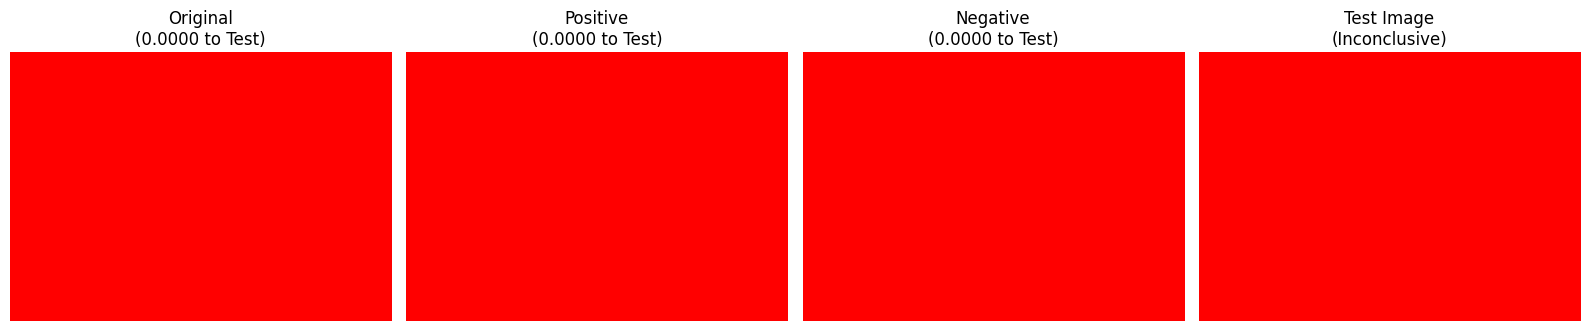

In [25]:
# prompt: generate code which takes 1 original image and 1 postive image and 1 negative image and claasify all new images which will be given

def classify_new_image(model, original_image, positive_image, negative_image, test_image, device, threshold_genuine=0.7, threshold_forged=0.3):
    """
    Classifies a new test image as 'Genuine' or 'Forged' based on comparison
    with an original, a known genuine (positive), and a known forged (negative) example.

    Args:
        model: Trained Siamese network model.
        original_image: PIL Image of a known genuine signature of the person.
        positive_image: PIL Image of another known genuine signature of the same person (different from original).
        negative_image: PIL Image of a known forged signature for that person, or a genuine signature from a different person.
        test_image: PIL Image of the signature to be classified.
        device: The device ('cuda' or 'cpu') to run the model on.
        threshold_genuine: Distance threshold below which test_image is considered similar to genuine examples.
        threshold_forged: Distance threshold above which test_image is considered similar to forged examples.
                         If the distance is between thresholds, the result is inconclusive.

    Returns:
        classification: 'Genuine', 'Forged', or 'Inconclusive'.
        genuine_distance: Distance between test_image and original_image.
        positive_distance: Distance between test_image and positive_image.
        negative_distance: Distance between test_image and negative_image.
    """
    transform = transforms.Compose([
        transforms.Resize((155, 220)),
        transforms.ToTensor()
    ])

    # Preprocess images
    original_tensor = transform(original_image).unsqueeze(0).to(device)
    positive_tensor = transform(positive_image).unsqueeze(0).to(device)
    negative_tensor = transform(negative_image).unsqueeze(0).to(device)
    test_tensor = transform(test_image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        # Calculate distances between test image and reference images
        # Distance to original
        out_orig, out_test1 = model(original_tensor, test_tensor)
        genuine_distance = F.pairwise_distance(out_orig, out_test1).item()

        # Distance to positive
        out_pos, out_test2 = model(positive_tensor, test_tensor)
        positive_distance = F.pairwise_distance(out_pos, out_test2).item()

        # Distance to negative
        out_neg, out_test3 = model(negative_tensor, test_tensor)
        negative_distance = F.pairwise_distance(out_neg, out_test3).item()

    # Simple classification logic based on distances
    # Consider the average distance to genuine examples (original and positive)
    avg_genuine_distance = (genuine_distance + positive_distance) / 2

    # If the test image is significantly closer to the genuine examples than the negative example
    if avg_genuine_distance < negative_distance and avg_genuine_distance < threshold_genuine:
        classification = 'Genuine'
    # If the test image is significantly closer to the negative example or far from genuine examples
    elif negative_distance < avg_genuine_distance and negative_distance > threshold_forged:
         classification = 'Forged'
    else:
        classification = 'Inconclusive' # Cannot make a clear decision

    return classification, genuine_distance, positive_distance, negative_distance

# Example usage (you would need to load your model and provide the images)

# Assuming 'model' is your trained SigNet model loaded from 'sig_net.pth' or a pickle file
# Assuming 'device' is set to 'cuda' or 'cpu'

# --- Placeholder for Loading Images ---
# In a real scenario, you would load these images from files, uploads, or the dataset
# For demonstration, we'll create dummy images. Replace this with actual image loading.

# Example of loading images from files (replace with your paths)
# try:
#     original_img_path = 'path/to/your/original_signature.png'
#     positive_img_path = 'path/to/your/positive_signature.png'
#     negative_img_path = 'path/to/your/negative_signature.png'
#     test_img_path = 'path/to/your/test_signature.png'

#     original_image_pil = Image.open(original_img_path).convert('RGB')
#     positive_image_pil = Image.open(positive_img_path).convert('RGB')
#     negative_image_pil = Image.open(negative_img_path).convert('RGB')
#     test_image_pil = Image.open(test_img_path).convert('RGB')

# except FileNotFoundError as e:
#     print(f"Error: Image file not found - {e}")
#     # Handle the error, perhaps exit or ask for valid paths
#     exit()
# except Exception as e:
#      print(f"An error occurred loading images: {e}")
#      exit()

# --- Example with Dummy Images (Replace with Real Loading) ---
# Create some dummy images for demonstration if you don't have files ready
# These won't represent real signatures, so classification results will be arbitrary.
print("--- Using Dummy Images for Demonstration ---")
dummy_img = Image.new('RGB', (220, 155), color = 'red') # Placeholder image
original_image_pil = dummy_img
positive_image_pil = dummy_img
negative_image_pil = dummy_img
test_image_pil = dummy_img
print("Dummy images created. Replace with actual image loading for meaningful results.")
print("-" * 40)

# --- Perform Classification ---
if 'model' in globals() and model is not None and 'device' in globals():
    print("Performing classification...")
    classification, gen_dist, pos_dist, neg_dist = classify_new_image(
        model,
        original_image_pil,
        positive_image_pil,
        negative_image_pil,
        test_image_pil,
        device,
        threshold_genuine=0.5,  # Adjust these thresholds based on your model's performance
        threshold_forged=0.7     # on a validation set
    )

    print(f"\nClassification Result: {classification}")
    print(f"Distance to Original: {gen_dist:.4f}")
    print(f"Distance to Positive: {pos_dist:.4f}")
    print(f"Distance to Negative: {neg_dist:.4f}")

    # Optional: Display the images used for classification
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    axes[0].imshow(original_image_pil)
    axes[0].set_title(f"Original\n({gen_dist:.4f} to Test)")
    axes[0].axis('off')

    axes[1].imshow(positive_image_pil)
    axes[1].set_title(f"Positive\n({pos_dist:.4f} to Test)")
    axes[1].axis('off')

    axes[2].imshow(negative_image_pil)
    axes[2].set_title(f"Negative\n({neg_dist:.4f} to Test)")
    axes[2].axis('off')

    axes[3].imshow(test_image_pil)
    axes[3].set_title(f"Test Image\n({classification})")
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

else:
    print("Error: Model or device not properly initialized. Please ensure previous cells were run correctly.")



Please upload the following images for classification:

Upload Original Signature:


Saving IMG_20250513_203643.jpg to IMG_20250513_203643 (1).jpg
Successfully loaded 'IMG_20250513_203643 (1).jpg' for Original Signature.

Upload Positive Signature (another genuine):


Saving IMG_20250513_203758.jpg to IMG_20250513_203758 (1).jpg
Successfully loaded 'IMG_20250513_203758 (1).jpg' for Positive Signature (another genuine).

Upload Negative Signature (a forged or different person's signature):


Saving IMG_20250513_204013.jpg to IMG_20250513_204013 (2).jpg
Successfully loaded 'IMG_20250513_204013 (2).jpg' for Negative Signature (a forged or different person's signature).

Upload Test Signature to classify:


Saving IMG_20250513_203720.jpg to IMG_20250513_203720 (1).jpg
Successfully loaded 'IMG_20250513_203720 (1).jpg' for Test Signature to classify.

Performing classification...

--- Classification Result ---
Classification: Genuine
Distance to Original: 0.0134
Distance to Positive: 0.0139
Distance to Negative: 0.0219
------------------------------


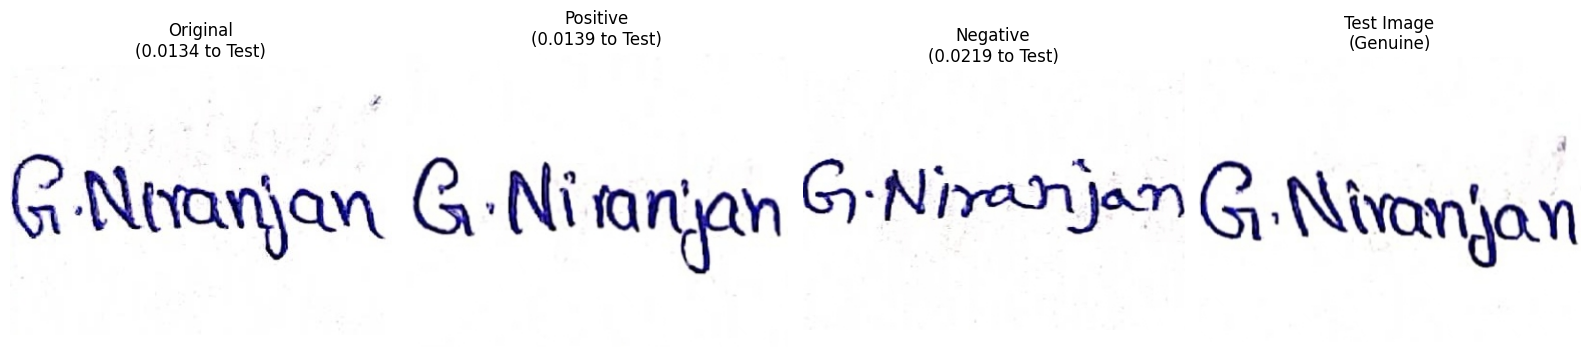

In [29]:
# prompt: take images from user to classify mention type of 4 images  for the above verification tell original postive negative and test image upload 1 by 1  file

# --- Interactive Image Upload and Classification ---

def upload_and_load_image(description):
    """Prompts user to upload an image and returns a PIL Image object."""
    print(f"\nUpload {description}:")
    uploaded = files.upload()
    if not uploaded:
        print(f"No file uploaded for {description}.")
        return None
    # Get the first file uploaded
    file_name = list(uploaded.keys())[0]
    img_bytes = uploaded[file_name]
    try:
        img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        print(f"Successfully loaded '{file_name}' for {description}.")
        return img
    except Exception as e:
        print(f"Error loading image '{file_name}': {e}")
        return None

# --- Upload Images ---
print("Please upload the following images for classification:")

original_image_pil = upload_and_load_image("Original Signature")
positive_image_pil = upload_and_load_image("Positive Signature (another genuine)")
negative_image_pil = upload_and_load_image("Negative Signature (a forged or different person's signature)")
test_image_pil = upload_and_load_image("Test Signature to classify")

# --- Perform Classification ---
if original_image_pil and positive_image_pil and negative_image_pil and test_image_pil:
    if 'model' in globals() and model is not None and 'device' in globals():
        print("\nPerforming classification...")
        # Adjust these thresholds based on your model's performance
        threshold_genuine = 0.5
        threshold_forged = 0.7

        try:
            classification, gen_dist, pos_dist, neg_dist = classify_new_image(
                model,
                original_image_pil,
                positive_image_pil,
                negative_image_pil,
                test_image_pil,
                device,
                threshold_genuine=threshold_genuine,
                threshold_forged=threshold_forged
            )

            print(f"\n--- Classification Result ---")
            print(f"Classification: {classification}")
            print(f"Distance to Original: {gen_dist:.4f}")
            print(f"Distance to Positive: {pos_dist:.4f}")
            print(f"Distance to Negative: {neg_dist:.4f}")
            print("-" * 30)


            # Optional: Display the images used for classification
            fig, axes = plt.subplots(1, 4, figsize=(16, 4))

            axes[0].imshow(original_image_pil)
            axes[0].set_title(f"Original\n({gen_dist:.4f} to Test)")
            axes[0].axis('off')

            axes[1].imshow(positive_image_pil)
            axes[1].set_title(f"Positive\n({pos_dist:.4f} to Test)")
            axes[1].axis('off')

            axes[2].imshow(negative_image_pil)
            axes[2].set_title(f"Negative\n({neg_dist:.4f} to Test)")
            axes[2].axis('off')

            axes[3].imshow(test_image_pil)
            axes[3].set_title(f"Test Image\n({classification})")
            axes[3].axis('off')

            plt.tight_layout()
            plt.show()

        except Exception as e:
             print(f"An error occurred during classification: {e}")

    else:
        print("Error: Model or device not properly initialized. Please ensure previous cells were run correctly.")
else:
    print("\nNot all required images were uploaded. Classification aborted.")

